# Implementing LSTM

Using Fake news classifier

# 1)- Import Key Modules

In [1]:
# support both Python 2 and Python 3 with minimal overhead.
from __future__ import absolute_import, division, print_function

# I am an engineer. I care only about error not warning. So, let's be maverick and ignore warnings.
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hassan.sherwani\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

# 2- Loading and preparing data

- Dataset: https://www.kaggle.com/c/fake-news/data#

In [4]:
df=pd.read_csv('train.csv')
df.shape

(20800, 5)

In [5]:
df.head(3)

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1


In [6]:
df.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [7]:
###Drop Nan Values
df=df.dropna()
df.shape

(18285, 5)

In [8]:
df.to_csv('ready_data.csv', index=0)

In [9]:
df=pd.read_csv('ready_data.csv')
df.shape

(18285, 5)

In [10]:
# check target variable for class balance
df.label.value_counts()

0    10361
1     7924
Name: label, dtype: int64

In [11]:
df.label.value_counts(normalize=True)

0    0.566639
1    0.433361
Name: label, dtype: float64

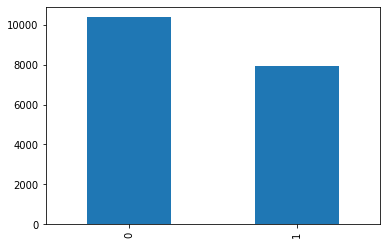

In [12]:
df.label.value_counts().plot(kind='bar')

### 2.1. Corpus building

1st clean data and then store

In [13]:
df.head(2)

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0


In [14]:
text_to_clean=df[['title']]
titles=text_to_clean.copy()

In [15]:
ps = PorterStemmer()
corpus = []
for i in range(0, len(titles)):
    review = re.sub('[^a-zA-Z]', ' ', titles['title'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

In [16]:
corpus[:5]

['hous dem aid even see comey letter jason chaffetz tweet',
 'flynn hillari clinton big woman campu breitbart',
 'truth might get fire',
 'civilian kill singl us airstrik identifi',
 'iranian woman jail fiction unpublish stori woman stone death adulteri']

In [17]:
df['clean']=corpus

In [18]:
## Get the Independent Features
X=df[['clean']]
## Get the Dependent features
y=df['label']

In [19]:
print(X.shape)
print(y.shape)

(18285, 1)
(18285,)


### 2.2.One_hot encoding

In [20]:
### Vocabulary size
voc_size=5000
onehot_repr=[one_hot(words,voc_size)for words in corpus] 
onehot_repr[:5]

[[4751, 4498, 3553, 1624, 1464, 1834, 651, 4949, 4452, 386],
 [3664, 3405, 2320, 4905, 878, 3114, 4319],
 [4076, 2223, 1060, 1306],
 [1747, 1733, 1468, 3430, 1608, 2138],
 [3791, 878, 1215, 1584, 711, 1532, 878, 4651, 3991, 805]]

[hous dem aid even see comey letter jason chaffetz tweet] is encoded as

[2620, 3271, 469, 1972, 4408, 2180, 4327, 2937, 2257, 2824]

### 2.3.Embedding Representation (padding)

In [21]:
#checking average sentence length
import numpy as np

average_length = np.mean([len(x) for x in X])
#median_length = sorted([len(x) for x in X])[len(X)  // 2]

In [22]:
print("Average sequence length: ", average_length)
#print("Median sequence length: ", median_length)

Average sequence length:  5.0


In [23]:
string=str(X)
sents =string.split('.')
avg_len = sum(len(x.split()) for x in sents) / len(sents)
avg_len

5.125

In [24]:
#padding based on our average length
sent_length=20
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs[:5])

[[   0    0    0    0    0    0    0    0    0    0 4751 4498 3553 1624
  1464 1834  651 4949 4452  386]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0 3664
  3405 2320 4905  878 3114 4319]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0 4076 2223 1060 1306]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
  1747 1733 1468 3430 1608 2138]
 [   0    0    0    0    0    0    0    0    0    0 3791  878 1215 1584
   711 1532  878 4651 3991  805]]


Notice that sentence lenth is 20 and our 1st sentence has 10 words. So all other words are padded as zeros.

# 3- Model

In [25]:
embedding_vector_features=40 # dimension of embedding layer
voc_size=5000
sent_length=20
output_layer= 1 
epochs=10
batch_size=64

### 3.1. Defining basic model architecture

In [26]:
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(LSTM(100 )) # one lstm layer with 100 neurons
model.add(Dense(output_layer,activation='sigmoid'))

In [27]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [28]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 40)            200000    
_________________________________________________________________
lstm (LSTM)                  (None, 100)               56400     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 256,501
Trainable params: 256,501
Non-trainable params: 0
_________________________________________________________________
None


##### Summary params calculation

https://datascience.stackexchange.com/questions/10615/number-of-parameters-in-an-lstm-model

**There are three steps:**

- For embedding layer: Dim of embedded layer(40) * vocab_size(5000)

- For LSTM Layer: Now formula is **#of params=g*[h(h+i)+biase]**

where g=lstm layer length i.e 1. For FFNS, RNN has 1 , LSTM has 4 and GRU has 3 layers<br>
h=hidden layer size (number of neurons in hidden layer) i.e 100<br> 
i=Input size/dimension i.e embedding_vector_features that is coming as an input on lstm layer in step2 (40 is value) <br>
biase= 100 of neurons for outpt of lstm layer

**4*[100(100+40)+100]**

- For Dense (Output): lstm layer acting as input(100) * neurons in output layer(1) + biase(1 as there is only one neuron in output layer)

In [29]:
len(embedded_docs),y.shape

(18285, (18285,))

In [30]:
X_final=np.array(embedded_docs)
y_final=np.array(y)

In [31]:
print(X_final.shape)
print(y_final.shape)

(18285, 20)
(18285,)


### 3.2.split train_test

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.20, random_state=42)

### 3.3.Model Training

In [33]:
history=model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=epochs,batch_size=batch_size)

Train on 14628 samples, validate on 3657 samples
Epoch 1/10
14628/14628 [==============================] - 6s 405us/sample - loss: 0.3031 - accuracy: 0.8570 - val_loss: 0.1925 - val_accuracy: 0.9136
Epoch 2/10
14628/14628 [==============================] - 4s 246us/sample - loss: 0.1348 - accuracy: 0.9463 - val_loss: 0.2022 - val_accuracy: 0.9188
Epoch 3/10
14628/14628 [==============================] - 3s 239us/sample - loss: 0.0964 - accuracy: 0.9632 - val_loss: 0.2159 - val_accuracy: 0.9185
Epoch 4/10
14628/14628 [==============================] - 4s 244us/sample - loss: 0.0746 - accuracy: 0.9736 - val_loss: 0.2432 - val_accuracy: 0.9122
Epoch 5/10
14628/14628 [==============================] - 4s 242us/sample - loss: 0.0547 - accuracy: 0.9821 - val_loss: 0.2733 - val_accuracy: 0.9141
Epoch 6/10
14628/14628 [==============================] - 4s 247us/sample - loss: 0.0369 - accuracy: 0.9878 - val_loss: 0.3097 - val_accuracy: 0.9070
Epoch 7/10
14628/14628 [===========================

### 3.4. evaluate model

In [34]:
y_pred=model.predict_classes(X_test)
y_pred[:5]

array([[1],
       [0],
       [0],
       [0],
       [1]])

In [35]:
confusion_matrix(y_test,y_pred)

array([[1864,  218],
       [ 120, 1455]], dtype=int64)

In [36]:
accuracy_score(y_test,y_pred)

0.9075745146294777

### 3.5.Plotting loss and accuracy scores

In [37]:
# for training set
loss, accuracy = model.evaluate(X_train, y_train, verbose=0)
print("Training Accuracy: {:.4f}".format(accuracy))
print("Training Loss: {:.4f}".format(loss))

Training Accuracy: 0.9990
Training Loss: 0.0049


In [38]:
# For test set
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
print("Testing Loss:  {:.4f}".format(loss))

Testing Accuracy:  0.9076
Testing Loss:  0.5213


In [39]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

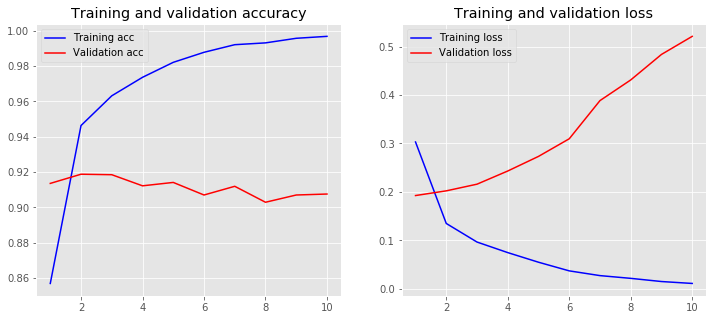

In [40]:
plot_history(history)

### 4- Improving model

- change activation function: from sigmoid to relu
- add dropout
- use earlystopping
- use balanced weight class
- use delta for learning rate

In [41]:
from tensorflow.keras.layers import Dropout
from keras.callbacks import EarlyStopping
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

Using TensorFlow backend.


### 4.1. define new model

In [42]:
model_dropout=Sequential()
model_dropout.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model_dropout.add(Dropout(0.3))
model_dropout.add(LSTM(100))
model_dropout.add(Dropout(0.3))
model_dropout.add(Dense(1,activation='relu'))
model_dropout.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model_dropout.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 40)            200000    
_________________________________________________________________
dropout (Dropout)            (None, 20, 40)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               56400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 256,501
Trainable params: 256,501
Non-trainable params: 0
_________________________________________________________________
None


In [43]:
history=model_dropout.fit(X_train,y_train,validation_data=(X_test,y_test),
                          class_weight=class_weights,epochs=epochs,batch_size=batch_size,
                          callbacks=[EarlyStopping(monitor='val_loss', patience=3, 
                                                   min_delta=0.0001)])

Train on 14628 samples, validate on 3657 samples
Epoch 1/10
14628/14628 [==============================] - 6s 389us/sample - loss: 0.4514 - accuracy: 0.8000 - val_loss: 0.2333 - val_accuracy: 0.9062
Epoch 2/10
14628/14628 [==============================] - 3s 239us/sample - loss: 0.3030 - accuracy: 0.8544 - val_loss: 0.2723 - val_accuracy: 0.8942
Epoch 3/10
14628/14628 [==============================] - 4s 242us/sample - loss: 0.2018 - accuracy: 0.9415 - val_loss: 0.3921 - val_accuracy: 0.9136
Epoch 4/10
14628/14628 [==============================] - 4s 240us/sample - loss: 0.1655 - accuracy: 0.9597 - val_loss: 0.4237 - val_accuracy: 0.9177


In [44]:
y_pred=model_dropout.predict_classes(X_test)
y_pred[:5]

array([[1],
       [0],
       [0],
       [1],
       [1]])

In [45]:
accuracy_score(y_test,y_pred)

0.9176920973475526

### 4.2. Plotting loss and accuracy scores

In [46]:
# for training set
loss, accuracy = model_dropout.evaluate(X_train, y_train, verbose=0)
print("Training Accuracy: {:.4f}".format(accuracy))
print("Training Loss: {:.4f}".format(loss))

Training Accuracy: 0.9750
Training Loss: 0.1235


In [47]:
# For test set
loss, accuracy = model_dropout.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
print("Testing Loss:  {:.4f}".format(loss))

Testing Accuracy:  0.9177
Testing Loss:  0.4237


In [48]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

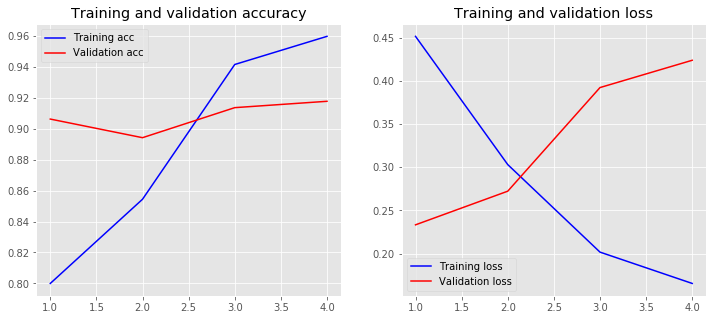

In [49]:
plot_history(history)

In [50]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.96      0.90      0.93      2082
           1       0.87      0.95      0.91      1575

    accuracy                           0.92      3657
   macro avg       0.91      0.92      0.92      3657
weighted avg       0.92      0.92      0.92      3657



In [51]:
cm=confusion_matrix(y_test,y_pred)
print(cm)

[[1865  217]
 [  84 1491]]


Populating the interactive namespace from numpy and matplotlib


<Figure size 720x720 with 0 Axes>

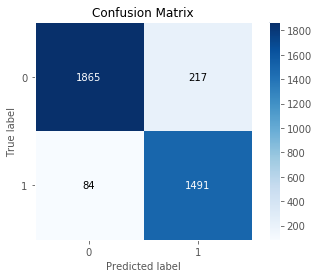

In [52]:
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline
import scikitplot as skplt
plt.figure(figsize=(10,10))
skplt.metrics.plot_confusion_matrix(y_test,y_pred)
plt.show()

### 4.3.weights at each step of neural network at each time step

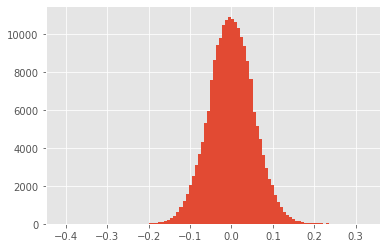

In [53]:
plt.hist(model.get_weights()[0].ravel(),100)
plt.show()

In [54]:
model.weights

[<tf.Variable 'embedding/embeddings:0' shape=(5000, 40) dtype=float32, numpy=
 array([[ 0.02214268,  0.04248355,  0.05595842, ..., -0.02033193,
          0.04759214,  0.0136544 ],
        [ 0.02575517,  0.04924141, -0.05658372, ..., -0.06777988,
          0.00444   ,  0.04368613],
        [ 0.07429782,  0.01409895,  0.02810419, ..., -0.07397592,
          0.07227699,  0.01396539],
        ...,
        [ 0.07635526,  0.12289315, -0.15514944, ..., -0.11445751,
          0.11464829,  0.10326262],
        [ 0.05201024,  0.09898616, -0.04086271, ..., -0.03109671,
          0.10120093,  0.05964844],
        [-0.00318298, -0.03624986, -0.0230121 , ..., -0.04481408,
          0.00515085,  0.0157474 ]], dtype=float32)>,
 <tf.Variable 'lstm/kernel:0' shape=(40, 400) dtype=float32, numpy=
 array([[-0.06516092, -0.00367892, -0.12180817, ..., -0.13185503,
         -0.15546152,  0.05678342],
        [-0.02190369, -0.1654223 , -0.16078281, ..., -0.14616016,
         -0.15224487,  0.11217792],
       